Config OK
Class mapping: {0: 'not fractured', 1: 'fractured'}
Found 8863 images belonging to 2 classes.
Found 600 images belonging to 2 classes.
Saved feature extractor: feature_extractor.keras
Extracting train features...
Extracting val features...
Shapes: (8863, 1280) (600, 1280)
Saved features to features\deep_features.npz
Training with xgb.train ...
[0]	train-logloss:0.67045	validation-logloss:0.67950
[1]	train-logloss:0.64946	validation-logloss:0.66482
[2]	train-logloss:0.62823	validation-logloss:0.65791
[3]	train-logloss:0.61129	validation-logloss:0.64642
[4]	train-logloss:0.59214	validation-logloss:0.63621
[5]	train-logloss:0.57590	validation-logloss:0.62631
[6]	train-logloss:0.55702	validation-logloss:0.61751
[7]	train-logloss:0.54009	validation-logloss:0.61124
[8]	train-logloss:0.52572	validation-logloss:0.60644
[9]	train-logloss:0.50887	validation-logloss:0.60435
[10]	train-logloss:0.49545	validation-logloss:0.60088
[11]	train-logloss:0.47995	validation-logloss:0.59275
[12]	t

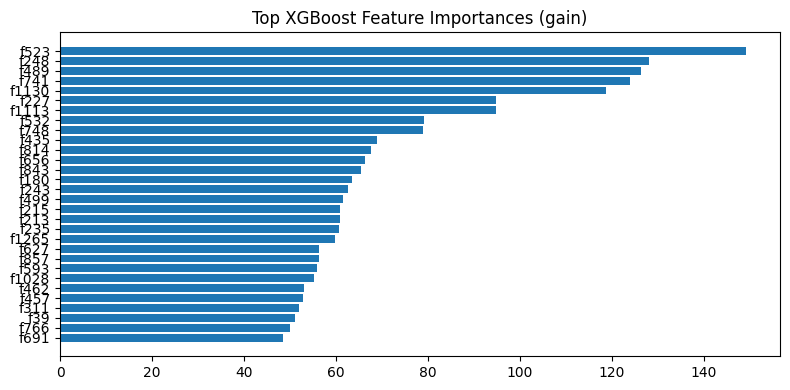

Done.


In [5]:
# %% [markdown]
# Tree on Deep Features (EfficientNetB0 + XGBoost booster)
# - Extracts deep features via EfficientNetB0
# - Trains XGBoost using xgb.train with early stopping
# - Saves artifacts: features/deep_features.npz, feature_extractor.keras, xgb_booster.json, xgb_model_meta.joblib

# %%
import os
import json
from pathlib import Path
import numpy as np
import joblib
import xgboost as xgb
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.efficientnet import EfficientNetB0, preprocess_input
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score
import matplotlib.pyplot as plt

# %%
# --- Configuration (edit paths if needed) ---
DATA_TRAIN = "data/train"
DATA_VAL = "data/val"
CLASS_INDICES_PATH = "class_indices.json"

FEATURES_DIR = Path("features")
FEATURES_DIR.mkdir(exist_ok=True)

FEATURE_EXTRACTOR_PATH = "feature_extractor.keras"   # .keras file (Keras 3.x)
BOOSTER_PATH = "xgb_booster.json"                    # saved native booster
XGB_META = "xgb_model_meta.joblib"                   # small metadata so other scripts can find the booster
FEATURES_NPZ_PATH = FEATURES_DIR / "deep_features.npz"

IMG_SIZE = (224, 224)
BATCH_SIZE = 32
RANDOM_STATE = 42

print("Config OK")

# %%
# --- Load class mapping ---
with open(CLASS_INDICES_PATH, "r") as f:
    class_indices = json.load(f)
idx_to_class = {v: k for k, v in class_indices.items()}
print("Class mapping:", idx_to_class)

# %%
# --- Data generators (EfficientNet preprocessing) ---
datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

def make_generator(directory, shuffle=False):
    return datagen.flow_from_directory(
        directory,
        target_size=IMG_SIZE,
        batch_size=BATCH_SIZE,
        class_mode='binary',
        classes=[idx_to_class[i] for i in sorted(idx_to_class.keys())],
        shuffle=shuffle
    )

train_gen = make_generator(DATA_TRAIN, shuffle=False)
val_gen = make_generator(DATA_VAL, shuffle=False)

# %%
# --- Build & save feature extractor in .keras format ---
feature_extractor = EfficientNetB0(weights='imagenet', include_top=False, pooling='avg',
                                   input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3))
feature_extractor.save(FEATURE_EXTRACTOR_PATH, include_optimizer=False)
print(f"Saved feature extractor: {FEATURE_EXTRACTOR_PATH}")

# %%
# --- Extract features helper ---
def extract_features_from_generator(gen, model):
    n_samples = gen.samples
    features = np.zeros((n_samples, model.output_shape[-1]), dtype=np.float32)
    labels = np.zeros((n_samples,), dtype=np.int32)
    filenames = []
    i = 0
    gen.reset()
    for batch_x, batch_y in gen:
        batch_features = model.predict(batch_x, verbose=0)
        b = batch_features.shape[0]
        features[i:i+b] = batch_features
        labels[i:i+b] = batch_y.astype(int).ravel()
        filenames.extend(gen.filenames[i:i+b])
        i += b
        if i >= n_samples:
            break
    return features, labels, filenames

print("Extracting train features...")
X_train_feats, y_train, train_files = extract_features_from_generator(train_gen, feature_extractor)
print("Extracting val features...")
X_val_feats, y_val, val_files = extract_features_from_generator(val_gen, feature_extractor)
print("Shapes:", X_train_feats.shape, X_val_feats.shape)

# %%
# --- Save features for fast re-use ---
np.savez_compressed(FEATURES_NPZ_PATH,
                    X_train=X_train_feats, y_train=y_train,
                    X_val=X_val_feats, y_val=y_val)
print(f"Saved features to {FEATURES_NPZ_PATH}")

# %%
# --- Train XGBoost using xgb.train with early stopping ---
dtrain = xgb.DMatrix(X_train_feats, label=y_train)
dval = xgb.DMatrix(X_val_feats, label=y_val)

params = {
    "objective": "binary:logistic",
    "eval_metric": "logloss",
    "eta": 0.05,
    "max_depth": 6,
    "seed": RANDOM_STATE,
    "verbosity": 1,
}
num_boost_round = 1000
early_stopping_rounds = 20
watchlist = [(dtrain, "train"), (dval, "validation")]

print("Training with xgb.train ...")
booster = xgb.train(
    params,
    dtrain,
    num_boost_round=num_boost_round,
    evals=watchlist,
    early_stopping_rounds=early_stopping_rounds,
    verbose_eval=True
)

# save booster
booster.save_model(BOOSTER_PATH)
joblib.dump({"booster_path": BOOSTER_PATH}, XGB_META)
print(f"Saved booster: {BOOSTER_PATH} and meta: {XGB_META}")

# %%
# --- Evaluate booster on validation set ---
y_val_proba = booster.predict(dval)
y_val_pred = (y_val_proba > 0.5).astype(int)

print("Confusion matrix:")
print(confusion_matrix(y_val, y_val_pred))
print("\nClassification report:")
print(classification_report(y_val, y_val_pred, target_names=[idx_to_class[0], idx_to_class[1]], digits=4))
try:
    print("ROC AUC:", roc_auc_score(y_val, y_val_proba))
except Exception as e:
    print("ROC compute failed:", e)

# %%
# Optional: plot top feature importance (gain)
importance = booster.get_score(importance_type='gain')
if importance:
    sorted_imp = sorted(importance.items(), key=lambda x: x[1], reverse=True)[:30]
    names, scores = zip(*sorted_imp)
    plt.figure(figsize=(8,4))
    plt.barh(range(len(scores))[::-1], scores)
    plt.yticks(range(len(scores))[::-1], names)
    plt.title("Top XGBoost Feature Importances (gain)")
    plt.tight_layout()
    plt.show()
else:
    print("No importance found.")

print("Done.")
